# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

#### Note: I have given a code cell number to every cell as a comment at the very beginning of every cell as follows : ## CODE CELL (number) ##. I will be referring to these in the explanation/writeup. Also refer to comments in the code.


In [1]:
## CODE CELL 1 ##

# Import necessary modules
import glob
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split

# Lesson functions (Code cell 2,3,4)

## Code Cell 2
Below are few of the lesson functions defined as follows:
* `get_hog_feastures()` - This is a function to extract HOG features from the image with an option to visualize the result or on extract the feature vector. it uses the `hog()` function from the skimage.feature package.
* `bin_spatial()` - This is a function to extract binned spatial color feature. The image is resized to 64x64 and extracted because the the training data is also 64x64 images.
* `color_hist()` - This function return the histogram of the pixel intensities the individual color channels and concatenates them to give a color histogram feature vector.
* `extract_features()` - This function extracts all of the above three features by a function call and concatenated all the features into a one big feature vector for an image.

In [2]:
## CODE CELL 2 ##

### Lesson functions ###

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=True)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


## Code Cell 3

* `add_heat()` - creates a heatmap for the list of bounding boxes rectagles it gets by adding +1 to it.
* `apply_threshold()` - This applies a threshold to the heatmap to remove false positives fro  the heatmap.
* `draw_labeled_bboxes()` - Draws a bounding box with the thresholded heatmap and overlays it on the original image.

In [3]:
## CODE CELL 3 ##

### Lesson functions for removing false positives (Heatmap) ###

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,30,100), 5)
    # Return the image
    return img


## Code cell 4

* `convert_color()` -  This function is just used to convert the image to another colorspace.
* `find_cars()` -  This function is used to extract features using hog sub-sampling and make predictions. Here the HOG for the entire image is calculated and the its subsampled according to the scale provided. I have used 3/4 scales for the images. But while processing for the video I used only 2 becuase processing was taking too long (around 40-50 min). Using 3 scales got me good results on all the test images.

In [20]:
## CODE CELL 4 ##

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    for scale in scales:
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    #spatial_features, 
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,30,100),5) 
                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return bboxes, draw_img

## Code Cell 5

Here we start by extracting the path names for the all the images for the training data set. We store them in separate lists for car and non_car images.

In [5]:
## CODE CELL 5 ##

### START ###

basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []

for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of vehicle images found',len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []

for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of non-vehicle images found',len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

Number of vehicle images found 8792
Number of non-vehicle images found 8968


## Code Cell 6

In this cell the RGB image is converted to YCrCb colorspace and the HOG features are extracted from each channel.
The results for Car and Non-Car images are displayed in the output of code cell 6. We can see that in the Y channel we can see the shape of the car. The YCrCb and YUV colorspace do an equally good job. Both with test accuracy 98.5-99.5 percent. Also the HSV colorspace, but sometimes test accuracy dropr to 97% . So I chose to go with YCrCb as it gave better HOG features (at least visually).


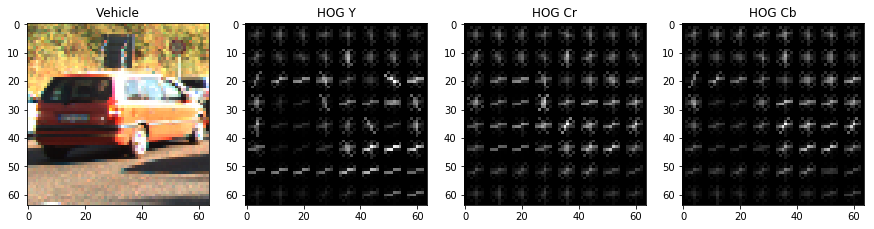

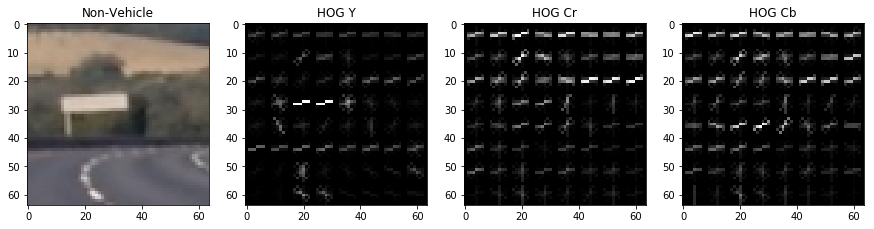

In [6]:
## CODE CELL 6 ##

# Generate a random index to look at a car image
#ind = np.random.randint(0, len(cars))
# Read in the image
image_car = cv2.imread(cars[6646])
YCrCb_img_car = convert_color(image_car, conv = 'BGR2YCrCb')
image_not_car = cv2.imread(notcars[256])
YCrCb_img_notcar = convert_color(image_not_car, conv = 'BGR2YCrCb')
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_car=[]
hog_notcar=[]
# Call our function with vis=True to see an image output
for ch in range(0,3):
    hog_car.append(get_hog_features(YCrCb_img_car[:,:,ch], orient, pix_per_cell, cell_per_block, vis=True)[1])
    hog_notcar.append(get_hog_features(YCrCb_img_notcar[:,:,ch], orient, pix_per_cell, cell_per_block, vis=True)[1])
    
    
fig = plt.figure(1, figsize=(15, 9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(image_car, cv2.COLOR_BGR2RGB))
plt.title('Vehicle')
plt.subplot(142)
plt.imshow(hog_car[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_car[1], cmap='gray')
plt.title('HOG Cr')
plt.subplot(144)
plt.imshow(hog_car[2], cmap='gray')
plt.title('HOG Cb')
fig = plt.figure(2, figsize=(15,9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(image_not_car, cv2.COLOR_BGR2RGB))
plt.title('Non-Vehicle')
plt.subplot(142)
plt.imshow(hog_notcar[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_notcar[1], cmap='gray')
plt.title('HOG Cr')
plt.subplot(144)
plt.imshow(hog_notcar[2], cmap='gray')
plt.title('HOG Cb')

hog_car = None
hog_notcar = None

# Parameter Cell (Code Cell 7)

There are a few parameters which can be tuned as shown below. I setled with the below HOG parameters as this gave me good results as shown above. Increasing the number of hist_bins, pix_per_cell or spatial size caused the pipeline a lot of time to train and also my RAM was getting almost completely used up. These parameters gave me decent results without slowing down my laptop too much.

In [7]:
## CODE CELL 7 ##

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [480, None] # Min and max in y to search in slide_window()

## Code Cell 8, 9 and 10

In code cell 8 the car features i.e. spatial,histogram and HOG features are extracted. Similarly features for the non-car features are extracted in code cell 9. In code cell 10 both the features are stacked to give a humungous feature matrix.

In [8]:
## CODE CELL 8 ##

# Extracting car features
print('Extracting car features...')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
len_car = len(car_features)
print('Done extracting')

  0%|          | 3/8792 [00:00<05:05, 28.77it/s]

Extracting car features...


100%|██████████| 8792/8792 [01:04<00:00, 141.41it/s]

Done extracting


In [9]:
## CODE CELL 9 ##

# Extracting non-car features
print('Extracting non-car features...')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
len_notcar = len(notcar_features)
print('Done extracting')

  0%|          | 12/8968 [00:00<01:15, 118.70it/s]

Extracting non-car features...


100%|██████████| 8968/8968 [01:09<00:00, 128.61it/s]

Done extracting


In [10]:
## CODE CELL 10 ##
# Joining car and non-car features
X = np.vstack((car_features, notcar_features)).astype(np.float64)

print('Feature stacking complete')

car_features = None      #Clearing variables not used further because CPU was running out of memory
notcar_features = None

Feature stacking complete


## Code Cell 11

I used the `Standardscaler().fit()` from sklearn to finf the mena and standard deviation and then standardization by centering and scaling. Default parameters were used for this. 

In [11]:
## CODE CELL 11 ##

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
X = None
print('features scaled')

features scaled


## Code cell 12

We generate labels for the dataset. Assigning 1 for the car images and 0 for the non car images.

In [ ]:
## CODE CELL 12 ##

# Define the labels vector
y = np.hstack((np.ones(len_car), np.zeros(len_notcar)))
print('Labels generated')

In [13]:
## CODE CELL 13 ##    (SPLITTING DATASET INTO TRAINING AND TEST SET)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


## Code Cell 14

I used a SVM classifier for for the training. It gave me good results ranging fro  97-99 % when I changed parameters. Output dsplays the time required for training and the test accuracy.  

In [14]:
## CODE CELL 14 ##

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

X_train = None
X_test = None
y_train = None
y_test = None

392.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


In [76]:
## CODE CELL 15 ##

## Create dictionary to pickle the data ##
data = {}
data['svc'] = svc
data['scaler'] = X_scaler
data['normalized_data'] = scaled_X
data["orient"] = orient
data["pix_per_cell"] = pix_per_cell
data["cell_per_block"] = cell_per_block
data["spatial_size"] = spatial_size
data["hist_bins"] = hist_bins

In [ ]:
## CODE CELL 16 ## (saving dictionary into a pickle file)

#import pickle

#with open('save_data.p', 'wb') as f:
#    pickle.dump(data, f)

In [ ]:
## CODE CELL 17 ## (loading pickled data)

import pickle
dist_pickle = pickle.load( open("save_data.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
scaled_X = dist_pickle["normalized_data"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

## Code Cell 18

This code cell is like a pipeline for the test images. It reads in an image. The `find_cars()` function extracts the HOG, spatial and histogram features of the image and then runs it through the classifier to detect cars in the image. `find_cars()` returns a list of bounding boxes co ordinates and the bounding boxes drawn on images.   

The bounding boxes list returned by `find_cars()` function may contain false positives detection too. To tackle this problem we create a heatmap. Since the same car is detected by multiple scaled windows we add +1 for each bounding box. Since the bounding boxes overlap the heatmap intensity increases where there are multiple detections and low heatmap value for false positives. I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.
Output of this cell is an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()`(center column images) and the bounding boxes then overlaid on the last frame of video.

The output of Code Cell 18 shows images as follows from left to right:   

(bounding box with false +ves) --> (Single bounding box for the heatmap) --> (heatmap)

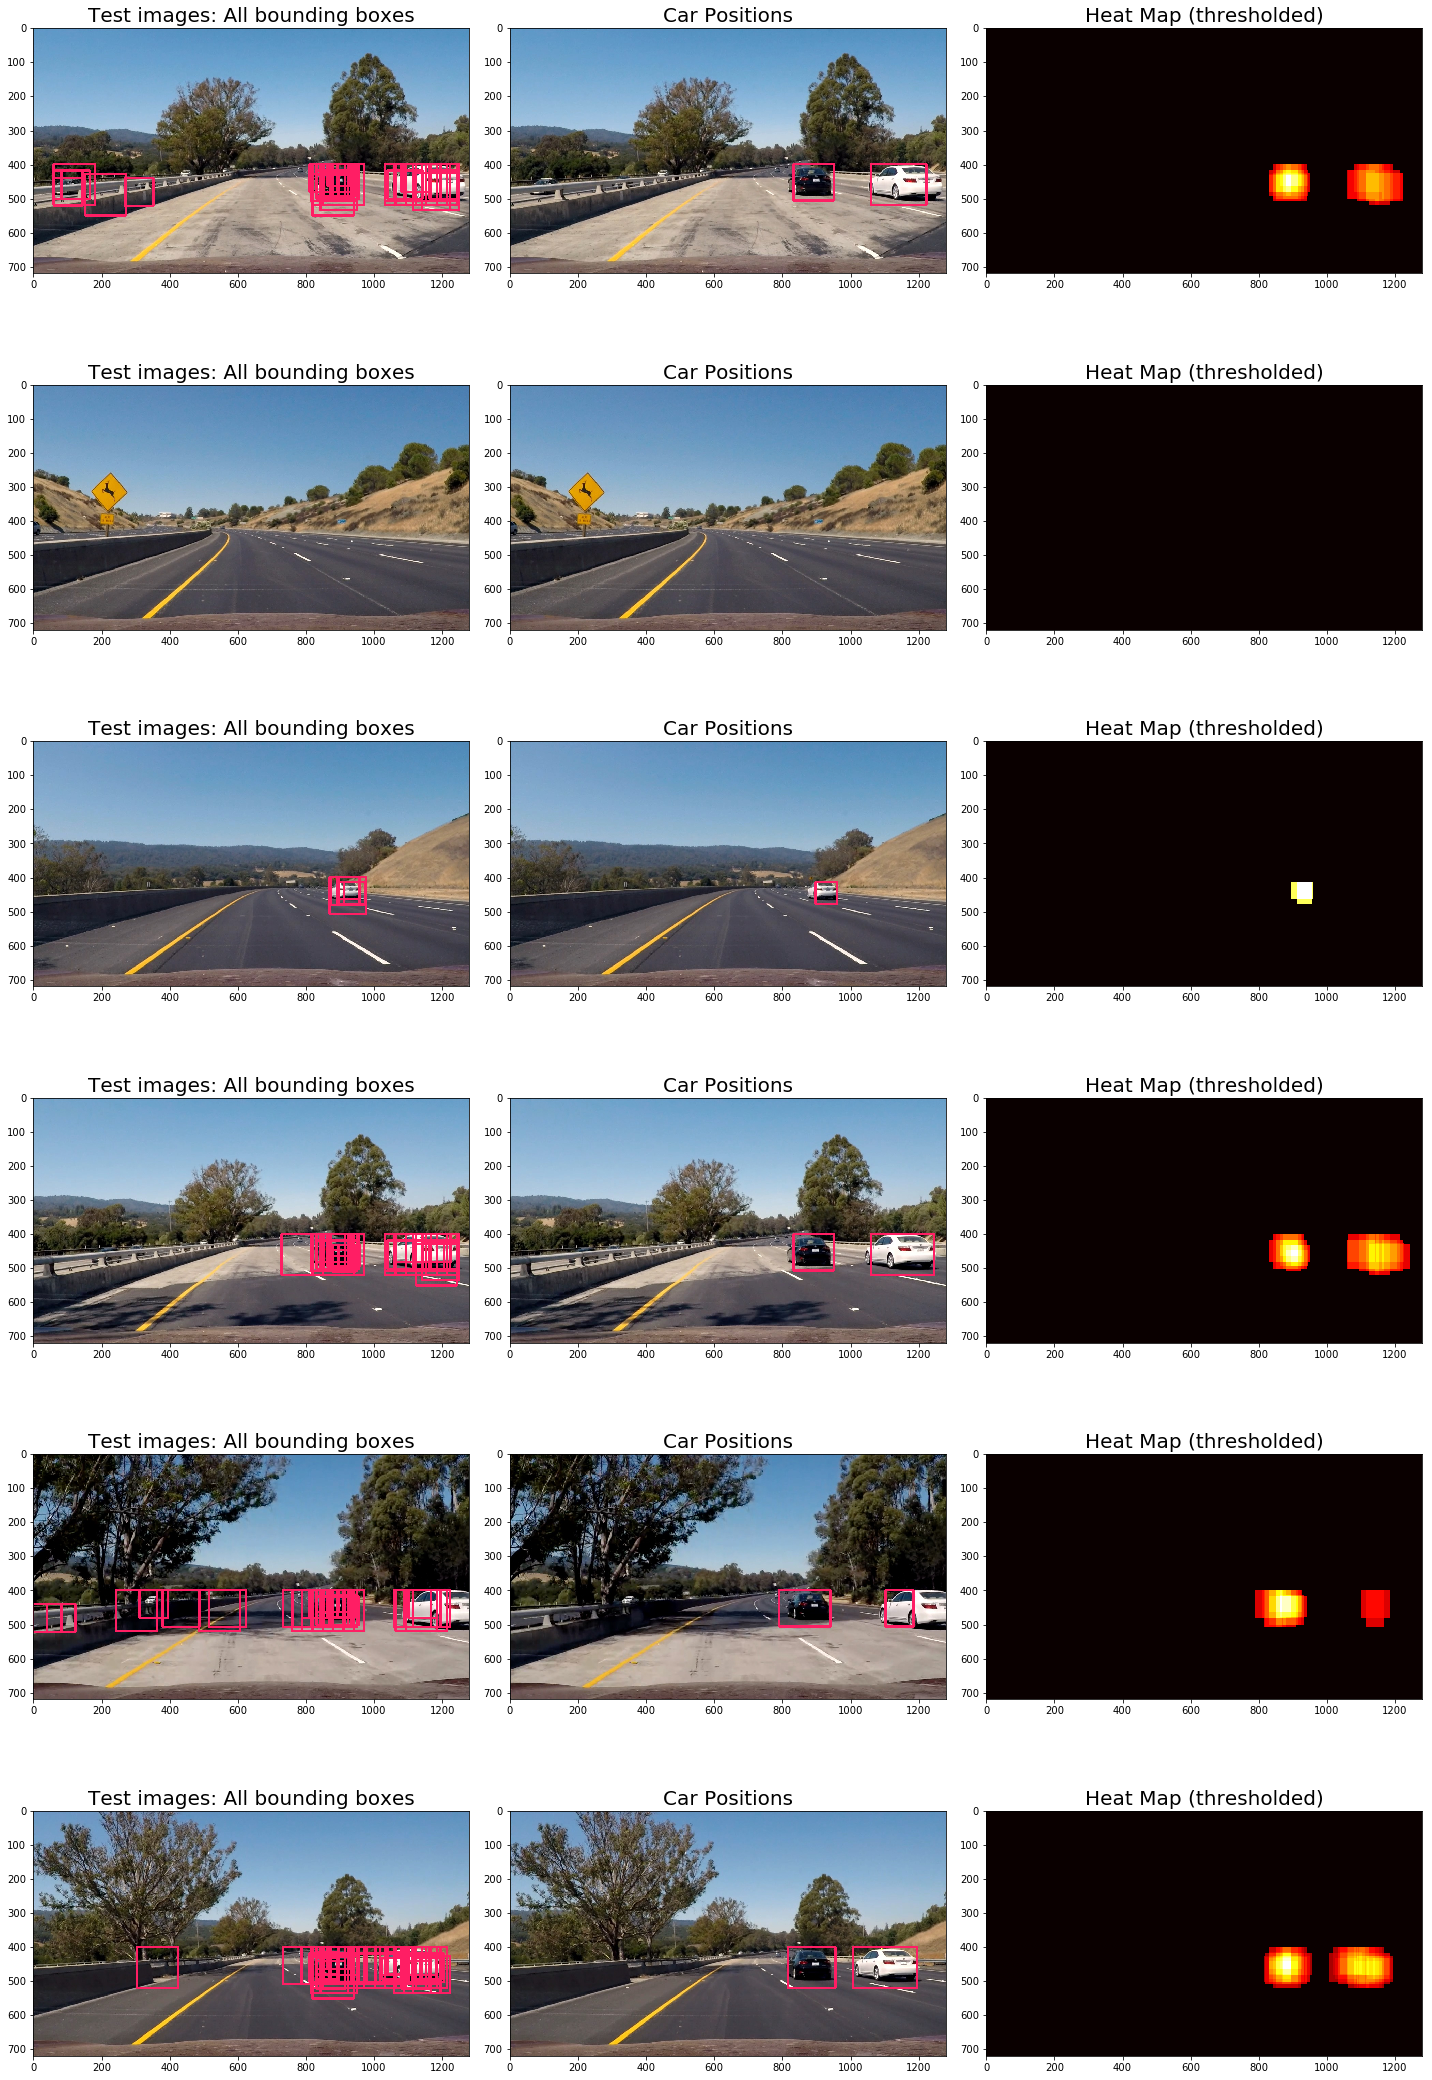

In [104]:
## CODE CELL 18 ##
test_imgs = glob.glob('./test_images/*.jpg')
ystart = 400  # region where cars are searched for
ystop = 656
scales = [1,1.3,1.7,1.9]  #Different scales used for subsampling

pos = 1  # variable for image plotting purpose specifying position 
for path in test_imgs:
    test_img = mpimg.imread(path)
    
    box_list, out_img = find_cars(test_img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    
    fig = plt.figure(3, figsize=(20, 30))
    plt.subplot(6,3,pos)
    plt.imshow(out_img)
    plt.title('Test images: All bounding boxes', fontsize=20)
    pos+=1
    plt.subplot(6,3,pos)
    plt.imshow(draw_img)
    plt.title('Car Positions', fontsize=20)
    pos+=1
    plt.subplot(6,3,pos)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map (thresholded)', fontsize=20)
    pos+=1
    
fig.tight_layout()

## Code Cell 19,20,21,22,23

19 - This code cell is very similar to Code cell 18. `process_image()` function uses `prev_bboxes` variable which is defined outside the funtion to store the values of the bounding boxes for the past 10 frames. It uses these values to create the heat map and draw the resulting bounding boxes. I have used only to scales becauase two scales itself took about 23 mins in to process. 

20,21 -  These cells produce the output for the test video and displays it.  

22,23 - These cells produce the output for the project video and displays it.

In [175]:
## CODE CELL 19 ##

def process_image(image):
    global prev_bboxes
    
    ystart = 400
    ystop = 656
    scales = [1.3,1.6]
             
    bboxes = find_cars(image, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[0]      

    prev_bboxes.append(bboxes)
    prev_bboxes = prev_bboxes[-10:]
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, [bbox 
                           for bboxes in prev_bboxes 
                           for bbox in bboxes]) 

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 12)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [121]:
## CODE CELL 20 ##

from moviepy.editor import VideoFileClip
from IPython.display import HTML

prev_bboxes = []

test_output_file = "NEWtest_video_output.mp4"
test_video = VideoFileClip("test_video.mp4")

test_output = test_video.fl_image(process_image)
%time test_output.write_videofile(test_output_file, audio=False)

[MoviePy] >>>> Building video NEWtest_video_output.mp4
[MoviePy] Writing video NEWtest_video_output.mp4



 97%|█████████▋| 38/39 [00:43<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: NEWtest_video_output.mp4 

CPU times: user 41 s, sys: 1.88 s, total: 42.9 s
Wall time: 45.3 s


In [122]:
## CODE CELL 21 ##

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output_file))

In [123]:
## CODE CELL 22 ##

prev_bboxes = []

project_output_file = "NEWproject_video_output.mp4"
project_video = VideoFileClip("project_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video NEWproject_video_output.mp4
[MoviePy] Writing video NEWproject_video_output.mp4



100%|█████████▉| 1260/1261 [23:00<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: NEWproject_video_output.mp4 

CPU times: user 22min 2s, sys: 54.8 s, total: 22min 56s
Wall time: 23min 2s


In [124]:
## CODE CELL 23 ##

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output_file))

# Discussion

Overall the cars are detected well in the project video. As you might observe in the video there are still sometimes false positive detection. It could have possibly been corrected if I would have run 3 or 4 scales to remove them. Processing 3/4 scales was taking an hour to process on the project video. Even using the past frames did not remove the false positives. I wonder what might be causing it. Maybe the classifier has to be trained better.   
Also prediction where the car might be by using past positions may help to track the car faster and better in real time. When cars are behind one another from the camera's perspective the hidden car cant be tracked using the current implementation. Being able to track it could be really helpful in unfortunate circumstamces for example when the driver suddenly moves into the drivers lane. That way appropriate actions could be taken by the car to avoid collision.

Please suggest techniques to improve the pipeline and make it robust. Thank you! :)